In [1]:
import numpy as np
import polars as pl
import pandas as pd
from sklearn.base import clone
from copy import deepcopy
import optuna
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt
import seaborn as sns

import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import *
from sklearn.metrics import *

SEED = 42
n_splits = 5

/home2/y2023/m2311203/.conda/envs/CMI2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

train = pd.read_csv('../input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('../input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('../input/child-mind-institute-problematic-internet-use/sample_submission.csv')

train_ts = load_time_series("../input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("../input/child-mind-institute-problematic-internet-use/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00,  4.38it/s]


In [3]:
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")
train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)
featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

"""This Mapping Works Fine For me I also Check Each Values in Train and test Using Logic. There no Data Lekage."""

for col in cat_c:
    mapping_train = create_mapping(col, train)
    mapping_test = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping_train).astype(int)
    test[col] = test[col].replace(mapping_test).astype(int)

print(f'Train Shape : {train.shape} || Test Shape : {test.shape}')

Train Shape : (2736, 155) || Test Shape : (20, 154)


In [ ]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)


def qwk_obj(preds, dtrain):
    # ラベルを直接渡す
    labels = dtrain
    
    # クリップ操作で予測値の範囲を制限
    y_min, y_max = 0, 3  # 必要に応じて範囲を設定
    preds = np.clip(preds, y_min, y_max)

    # 目的関数の定義に基づくコスト関数の勾配（grad）とヘッセ行列（hess）
    df = preds - labels  # ラベルとの差分
    grad = df  # 勾配としてラベルとの差を使用
    hess = np.ones_like(labels)  # ヘッセ行列は1で設定（この例では簡素化）

    return grad, hess

In [32]:
X = train.drop('sii', axis=1)
y = train['sii']
y_min = y.min()
y_max = y.max()
a = y.mean()
b = y.var(ddof=0)

In [35]:
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_squared_log_error
import numpy as np

RAND_VAL = 42
num_folds = 5  # Number of folds
n_est = 30000
num_seeds = 1

all_RMSLE_vals = []
var_list = []

for seed in range(num_seeds):
    print(f"Seed {seed}")

    KFold = StratifiedKFold(n_splits=num_folds, random_state=RAND_VAL, shuffle=True)
    QWK_vals = []
    test_preds = np.empty((num_folds, len(test)))

    for num_fold,(train_idx,val_idx) in enumerate (KFold.split(X,y)):
        X_train ,X_val = X.iloc[train_idx],X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx],y.iloc[val_idx]

        model = LGBMRegressor(n_estimators=n_est, random_state=RAND_VAL)

        params = {
            "objective": qwk_obj,
            "metric": "None",
            'boosting_type': 'gbdt',
            'learning_rate': 0.01,
            'max_depth': -1,
            'num_leaves': 31,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1,
            'n_jobs': -1,
            'seed': RAND_VAL
        }
        model.set_params(**params)

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[early_stopping(stopping_rounds=100), log_evaluation(1000)]
        )
        y_pred = model.predict(X_val)
        y_pred = np.clip(y_pred, 0, 3)
        RMSLE = np.sqrt(mean_squared_log_error(y_val, y_pred))
        print(f"Fold {num_fold} RMSLE: {RMSLE}")
        all_RMSLE_vals.append(RMSLE)
        y_pred = model.predict(test)
        test_preds[num_fold] = y_pred

print(f"Mean RMSLE: {np.mean(all_RMSLE_vals)}")
all_RMSLE_vals.append(np.mean(all_RMSLE_vals))

Seed 0


ValueError: For early stopping, at least one dataset and eval metric is required for evaluation

In [19]:
submission = test_preds.mean(axis=0)
submission = np.clip(submission, 0, 3)
#四捨五入して整数で出力
submission = np.round(submission).astype(int)
sample['sii'] = submission
sample.to_csv('submission.csv', index=False)

In [18]:
submission

array([0.64433489, 0.20184658, 0.4520281 , 0.38242214, 0.62714429,
       0.66916834, 0.47031705, 0.2853563 , 0.81818921, 0.62822496,
       0.50150184, 0.51443688, 0.95857133, 0.78220182, 0.73478255,
       0.82423832, 0.12433319, 0.29652258, 0.42425398, 0.66132542])

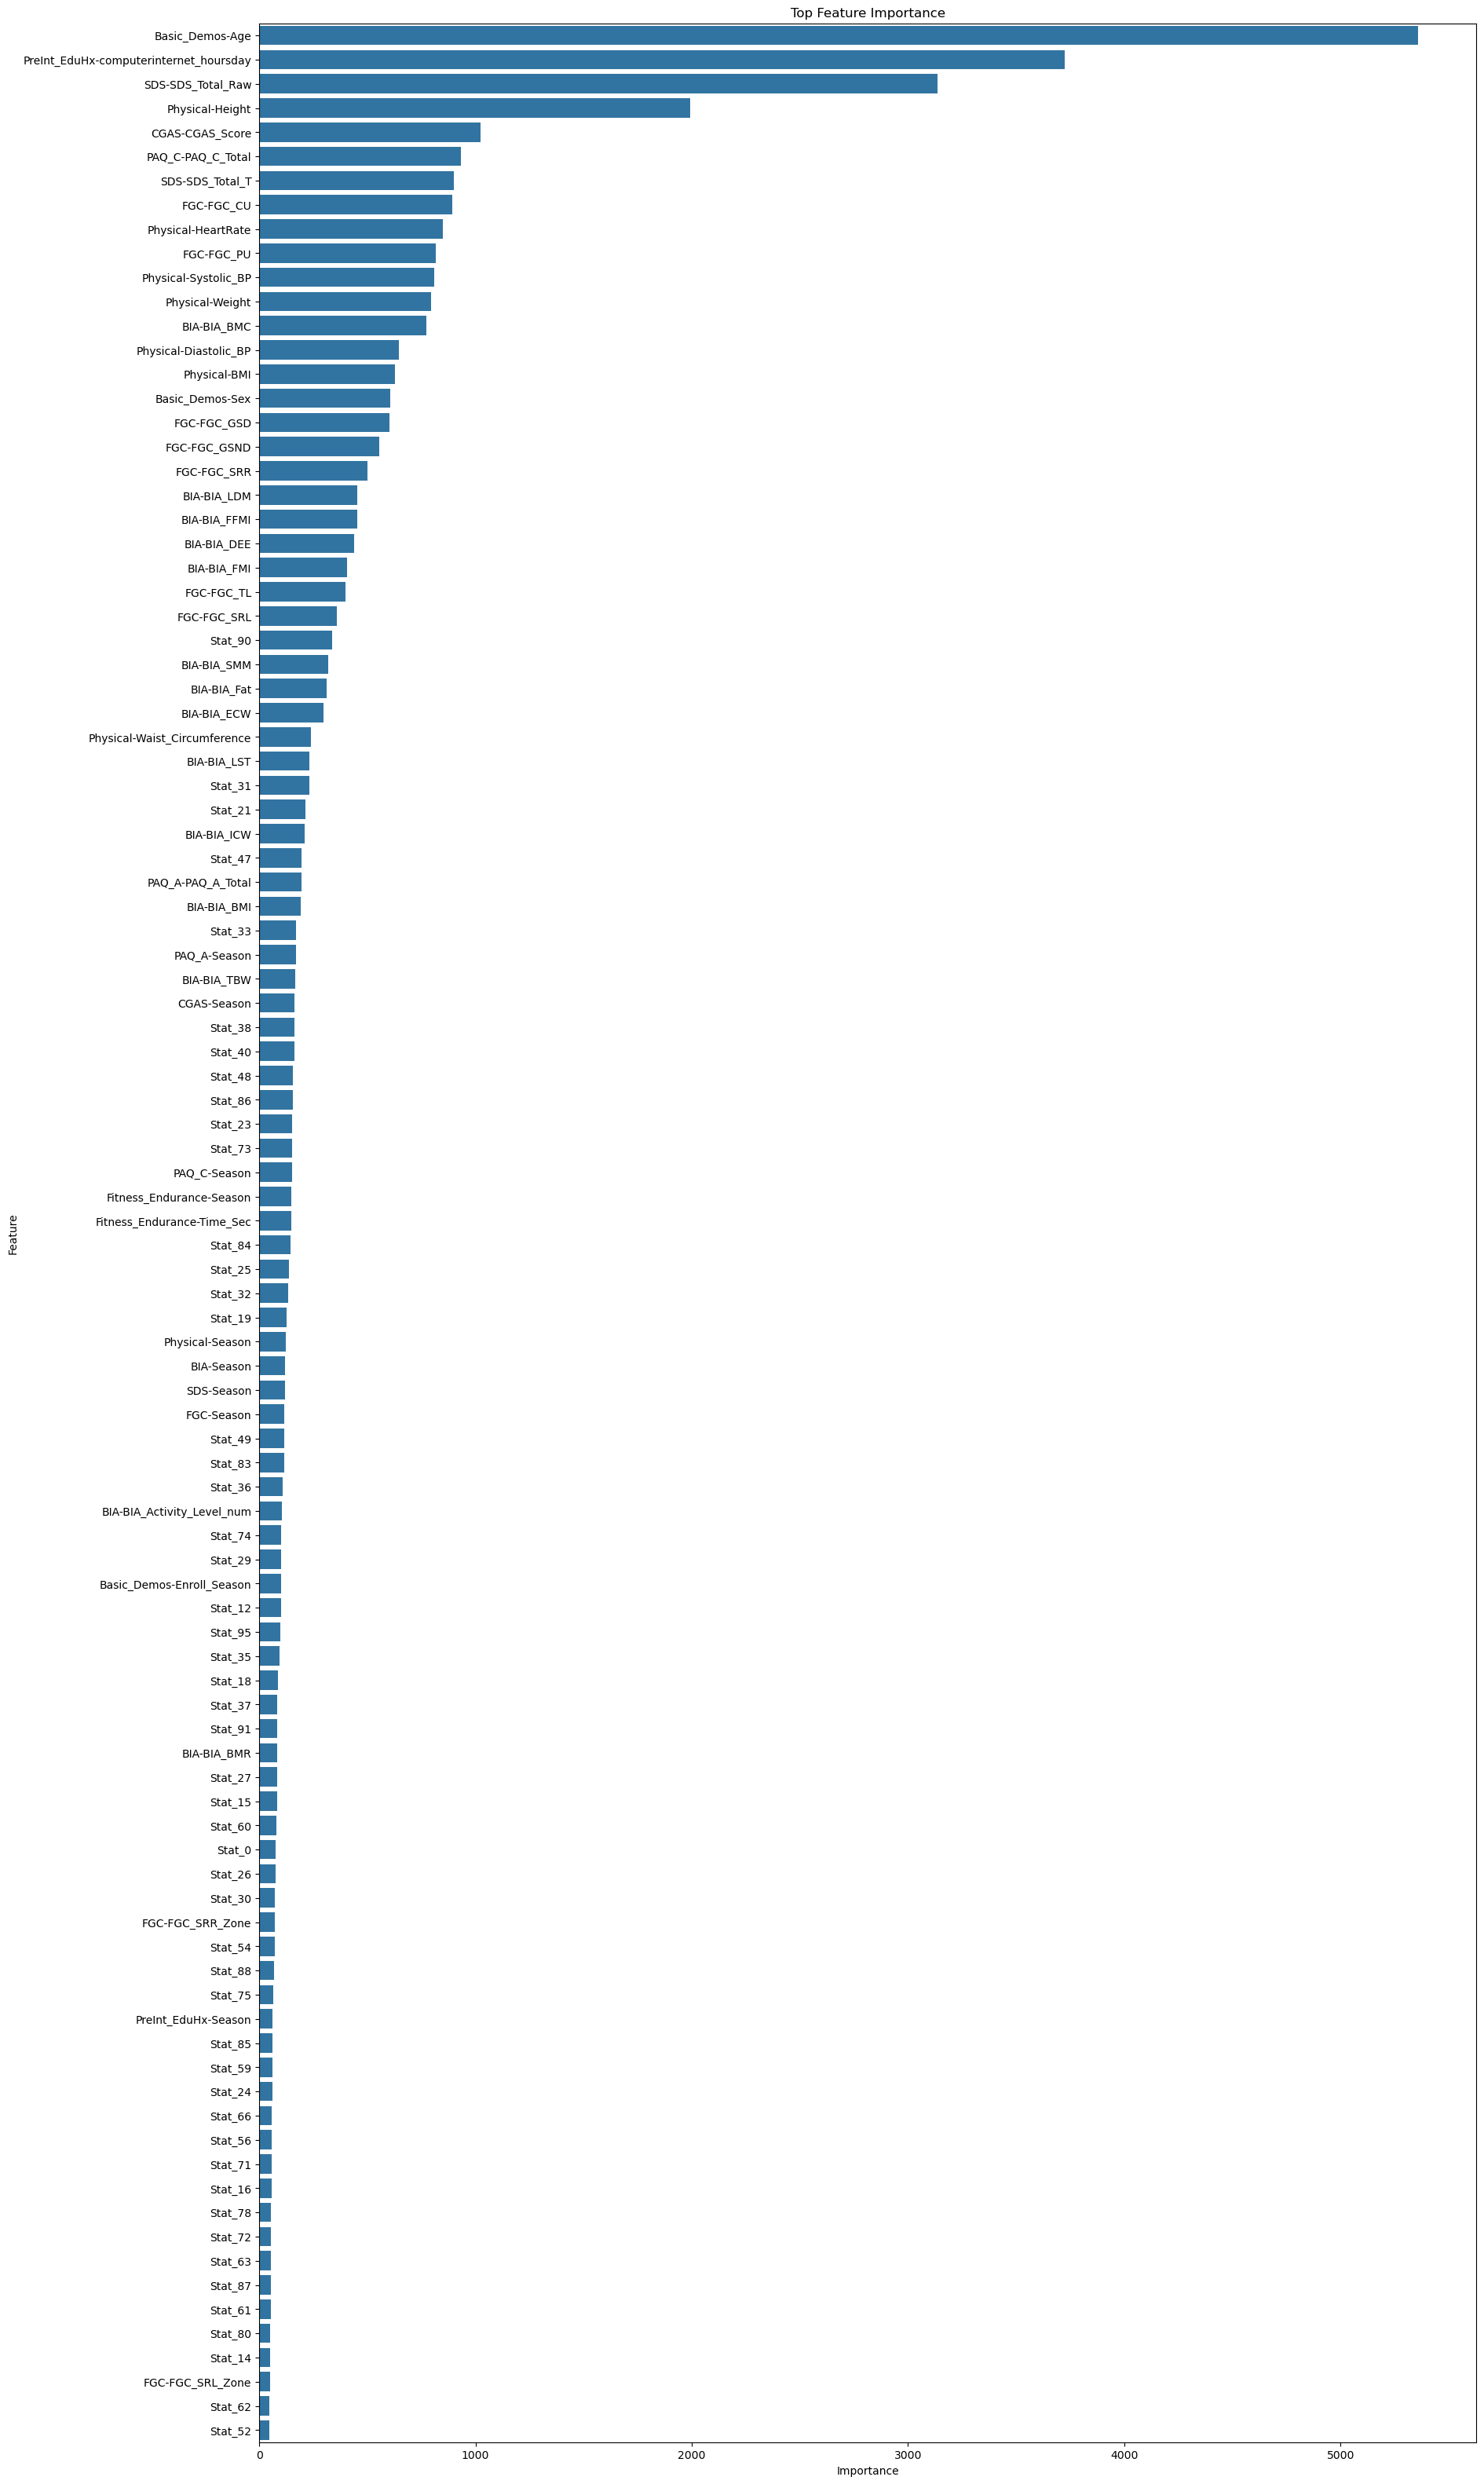

In [15]:
feature_importance_df = pd.DataFrame({
    'Feature': model.booster_.feature_name(),
    'Importance': model.booster_.feature_importance(importance_type='gain')
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(20, 40))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(100)) 
plt.title("Top Feature Importance")
plt.show()